# Home Credit Project Summary

In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import auxiliary.lists as aux_lists
import auxiliary.statistics as st
import auxiliary.transformers as tr
import auxiliary.eda_functions as eda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Markdown,display
import matplotlib.ticker as ticker
from tabulate import tabulate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
%aimport auxiliary.statistics
%aimport auxiliary.lists
%aimport auxiliary.transformers
%aimport auxiliary.eda_functions


In [2]:
sns.set()
BASE_FIG_SIZE=(8.5,4.5)
ALPHA=0.05

## Introduction

## Problems That This Projects Solves:

In [11]:
application_train=pl.read_csv('data/application_train.csv')
bureau_balance=pl.read_csv('data/bureau_balance.csv')
bureau=pl.read_csv('data/bureau.csv')
installments_payments=pl.read_csv('data/installments_payments.csv')
POS_CASH_balance=pl.read_csv('data/POS_CASH_balance.csv')
previous_application=pl.read_csv('data/previous_application.csv')
credit_card_balance=pl.read_csv('data/credit_card_balance.csv')
credit_data = pl.read_parquet("temp/active_credit_cards.parquet")
id_and_target=["SK_ID_CURR", "TARGET"]

## Goals

### Goal 1: Credit Default Risk

The primary objective of the first model is to predict whether the applicant will encounter challenges in repaying the loan.

**Displaying the target class balance:**

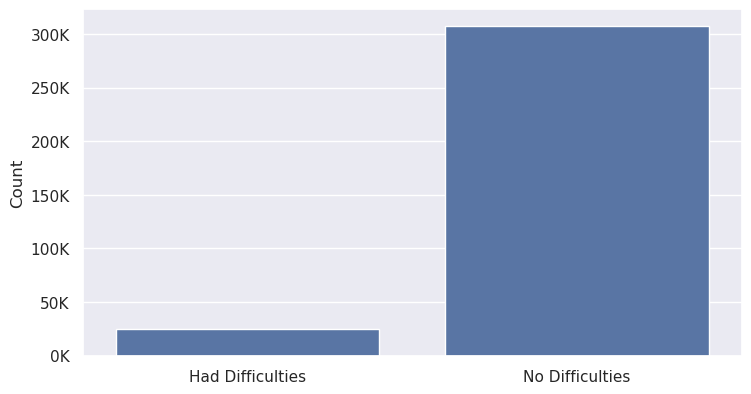

In [4]:
# | label: fig-target_balance
# | fig-cap: The number of applicants that had difficulties repaying their loan vs. those that had no difficulties.

fig_target_balance, ax_target_balance = plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(
    [application_train["TARGET"].sum(), len(application_train["TARGET"])],
    ax=ax_target_balance,
)
ax_target_balance.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)
ax_target_balance.set_xticks([0,1])
ax_target_balance.set_xticklabels(['Had Difficulties','No Difficulties'])
ax_target_balance.set_ylabel('Count')
fig_target_balance.savefig('summary_data/target_balance_chart.png')
plt.show()

#### Success Criteria

During the Exploratory Data Analysis, it was revealed that the company leverages three external data sources, incurring associated costs. The external data, being scaled and exhibiting an approximately normal distribution, serves as the basis for establishing a success baseline. To gauge this baseline, a rudimentary classifier is applied to the data, and its performance is evaluated. Given the simplicity and effectiveness of logistic regression with this data – achievable with just a single line of code – it is considered a current attainable benchmark for the company.

**Logistic Regression ROC AUC score based on external data:**

In [21]:
imputer = SimpleImputer()
log_reg_model = LogisticRegression(class_weight="balanced")
pipeline = Pipeline([("imputer", imputer), ("model", log_reg_model)])
print(
    round(
        np.array(
            cross_val_score(
                pipeline,
                application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]],
                application_train["TARGET"],
                scoring="roc_auc",
            )
        ).mean(),
        3,
    )
)

0.719


With the logistic regression model yielding a roc-auc score of 0.719 based on external data, two success criteria: can be set:
* **Best Case:** Our model autonomously outperforms the external data score, without depending on additional external data.
* **Acceptable:** The incorporation of our model contributes to an improvement in the external data score.

### Goal 2: Credit Over Limit Prediction

During the EDA it was noted that some credit cards are over balance limit for the current month @fig-over-limit. Therefore, as an additional benefit, the construction of a model aiming to predict whether the current month's credit balance will exceed the limit for a specific credit card offers valuable advantages. This model can serve to proactively issue warnings to credit card holders, providing them with timely alerts. Simultaneously, it enables the company to assess and manage internal capital risks more effectively by anticipating and addressing potential over-limit situations before they occur.

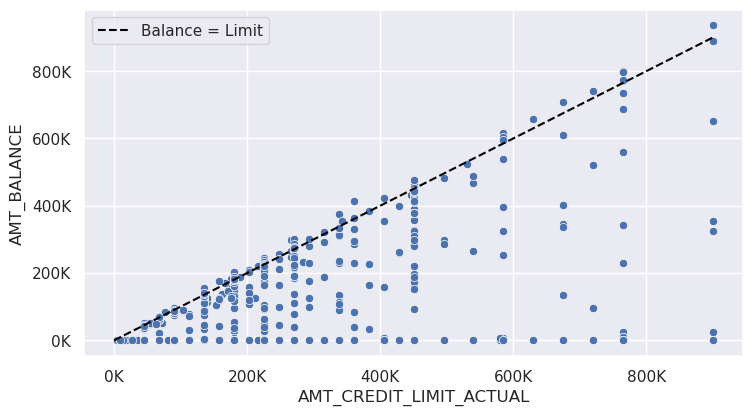

In [7]:
# | label: fig-over-limit
# | fig-cap: Credit card balance versus credit card limit for a random sample of n=1000. Points higher on the y-axis than the black line signify credit-cards over limit.
fig_balance, ax_balance = plt.subplots(figsize=BASE_FIG_SIZE)

sns.scatterplot(
    y=credit_card_balance.filter(pl.col("AMT_CREDIT_LIMIT_ACTUAL") > 0)
    .group_by("SK_ID_CURR")
    .agg(pl.all().sort_by("MONTHS_BALANCE").last())
    .sort("SK_ID_CURR")["AMT_BALANCE"]
    .sample(1000, seed=1),
    x=credit_card_balance.filter(pl.col("AMT_CREDIT_LIMIT_ACTUAL") > 0)
    .group_by("SK_ID_CURR")
    .agg(pl.all().sort_by("MONTHS_BALANCE").last())
    .sort("SK_ID_CURR")["AMT_CREDIT_LIMIT_ACTUAL"]
    .sample(1000, seed=1),
    ax=ax_balance,
)

x_bal = np.linspace(0, 900000)
sns.lineplot(
    x=x_bal,
    y=x_bal,
    label="Balance = Limit",
    linestyle="--",
    color="black",
    ax=ax_balance,
)

ax_balance.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)
ax_balance.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)

#### Success Criteria

Given the absence of existing methods for predicting credits over the limit, the success criteria for the new model will be grounded in the F-1 Score of a dummy classifier. This serves as a pragmatic benchmark for evaluating the model's performance in comparison to a simple baseline approach.

In [20]:
dummy_credit = DummyClassifier(strategy="stratified")
print(
    round(
        np.array(
            cross_val_score(
                dummy_credit,
                credit_data.drop(columns="IS_OVER_LIMIT"),
                credit_data["IS_OVER_LIMIT"],
                scoring="f1",
            )
        ).mean(),
        3,
    )
)

0.133
